# Проект Кредитного Скоринга
## Стадия Feature Engineering

Версия 08


Вводные. Задача кредитного скоринга по выявлению дефолтных клиентов.  Необходимо разработать и обучить модель, которая бы выявляла клиентов, которые совершат дефолт. Использовать можно только методы ML. В качестве метрики предложено использовать AUCROC.

Значения столбцов:
- client_id       - идентификатор клиента
- app_date    - дата заявки на кредит
- education       - уровень образования
- sex	            - пол заёмщика
- age	            - возраст заёмщика
- car	            - наличие автомобиля
- car_type        - автомобиль-иномарка
- decline_app_cnt	- количество отказанных прошлых заявок
- good_work       - наличие «хорошей» работы
- score_bki       - скоринговый балл из БКИ
- bki_request_cnt	- количество запросов в БКИ
- region_rating - рейтинг региона
- home_address	- категоризатор домашнего адреса
- work_address	- категоризатор рабочего адреса
- income	        - доход заёмщика
- sna       -   связь заемщика с клиентами банка
- first_time        - давность наличия информации о заемщике
- foreign_passport - наличие загранпаспорта
- default	        - наличие дефолта


Общее замечание.  Работа над задачей носит итеративный характер. В рамках одного ноутбука приходится многократно исполнять одни и те же ячейки без пользы. Принято решение разделить задачу по стадиям:
- Разведывательный анализ данных (EDA)
- Разработка признаков (FE)
- Подбор гиперпараметров (HPT)
- Формирование тестовых данных для соревнований на kaggle (KC).

Первые два шага будут выполнены локально. В облако kaggle будет загружена только последний ноутбук или вообще только конечные данные.

Это вторая из четырех рабочих книг.

In [41]:
from pandas import Series
import pandas as pd
import pandas_profiling
import numpy as np
from datetime import datetime, date
import time, gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,  GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
RANDOM_SEED = 42

 ## Вспомогательные функции

In [3]:
def print_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cmdf = pd.DataFrame(cm, index = ['actual 0', 'actual 1'], columns = ['detected 0', 'detected 1'])
    print(cmdf)
    g,a,b = g_score(cm)
    print(' ',
        'Accuracy:      {:.4f}'.format(accuracy_score(y_test, y_pred)),
#        'f1_score: {:.4f}'.format(f1_score(y_test, y_pred)),
        'Recall:        {:.4f}'.format(recall_score(y_test, y_pred)),
        'Precision:     {:.4f}'.format(precision_score(y_test,y_pred)),
        'MCC:           {:.4f}'.format(matthews_corrcoef(y_test, y_pred)),
        'AUCROC:        {:.4f}'.format(roc_auc_score(y_test,y_pred)),
        'Detection 0:   {:.4f}'.format(a),
        'Detection 1:   {:.4f}'.format(b),
        'Total G-Score: {:.4f}'.format(g),
        sep="\n")


In [4]:
def init_metrics(name=None):
    lm = ['Recall', 'Selectivity', 'FNR', 'FPR', 'Bal.Error', 'AUCROC', 'f1-score', 'MCC']
    return pd.Series(data=np.zeros(len(lm)),index=lm,name=name, dtype='float64')

In [5]:
def get_metrics(y_test, y_pred, probs, metr ):
    # v = init_metrics(name)
    cm = confusion_matrix(y_test, y_pred)
    TN = cm[0,0]; FP = cm[0,1]; FN = cm[1,0]; TP = cm[1,1]

    # v['Accuracy']=  round(accuracy_score(y_test, y_pred),4)
    metr['Recall'] +=    round(recall_score(y_test, y_pred, zero_division=0),4)
    metr['Selectivity'] += round(( TN/(TN+FP)),4)
    metr['FPR'] += round(( FP/(TN+FP)),4)
    metr['FNR'] += round(( FN/(TP+FN)),4)
    metr['Bal.Error'] += round( ((FN/(TP+FN))+(FP/(TN+FP)))/2 ,4)
    # v['Precision']= round(precision_score(y_test, y_pred, zero_division=0),4)
    metr['f1-score' ] += round(f1_score(y_test, y_pred, zero_division=0),4)
    metr['MCC'] +=       round(matthews_corrcoef(y_test, y_pred),4)
    metr['AUCROC'] +=    round(roc_auc_score(y_test, probs),4)
    return metr

In [6]:
# Evaluate basic model
def eval_basic_models(df, osm='None', list_models=[] ):
    # OSM = oversamplint method
    # train_df = df.drop(['client_id'], axis=1)
    was = time.perf_counter()   # замер времени работы
    _ = gc.collect()            #  принудительный сбор мусора
    X = df.drop(['default'], axis=1).values
    y = df['default'].values

    # RandomOverSampler, SMOTE, ADASYN
    oversamplers = {'RanOS': RandomOverSampler(),'SMOTE': SMOTE(),'ADASYN': ADASYN()}



    # X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=RANDOM_SEED )


    models = {
    # models with default settings
    'LogReg'  : LogisticRegression(max_iter=1000, n_jobs=-1), # fix ConvergenceWarning
    'DecTree' : DecisionTreeClassifier(),
    'ExtTree' : ExtraTreeClassifier(),
    'AdaBst'  : AdaBoostClassifier(n_estimators=100), # количество из демо примера
    'Bagg'    : BaggingClassifier( n_jobs=-1),
    'ExtEns'  : ExtraTreesClassifier(n_jobs =-1),
    'GradBst' : GradientBoostingClassifier(n_estimators=100),  # количество из примера
    'RanFrst' : RandomForestClassifier(n_jobs=-1) }

    if len(list_models) == 0:
        list_models = models.keys()

    metrics = init_metrics('E')   # пустышка для работы concat
    print('Model:', end=' ')

    for mname in list_models:
        # mname = '{}'.format(model).split('(')[0]
        print(mname, end=', ')
        metr=init_metrics(mname)
        #  Набор данных несбалансирован. Поэтому StratifiedKFold
        skf = StratifiedKFold(n_splits=5) # random_state=RANDOM_SEED) - для случая перетасовки
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            # Поскольку данные несбалансированные, можем выбрать увеличение количества меньшего класса с помощью
            # того или иного алгоритма
            if osm != 'None':
                sampler = oversamplers[osm]
                X_res, y_res = sampler.fit_resample(X_train, y_train)
            else:
                X_res = X_train; y_res = y_train

            models[mname].fit(X_res, y_res)
            y_pred = models[mname].predict(X_test)
            probs = models[mname].predict_proba(X_test)
            # probs = probs[:,1]
            # zero_division=0 to fix zero division Warning
            # print('Results for:', model)
            metr = get_metrics(y_test, y_pred, probs[:,1], metr )
            # конец цикла кроссвалиадции
        for k in metr.keys():
            metr[k] /= 5  # успеднение накопленных значений метрик
        metrics = pd.concat([metrics, metr], axis=1)
    print('done. {:.4f} sec'.format(time.perf_counter() - was))
    return metrics.drop(['E'],axis=1)

In [7]:
# Построение линейных графиков для сравнения моделей.
# Допустимо несколько линий одновременно
def compare_models_plot(assesment, metrics, tlt):
    cols = assesment.columns
    plt.figure(figsize = (20,5))
    for m in metrics:
        plt.plot(cols, [assesment.loc[m,c] for c in cols], label = m )
    plt.title(tlt, fontsize=14)
    plt.legend(loc='best')
    plt.show();

In [8]:
# Построение графика из столбиков для сравнения моделей.
# Допустима только одна метрика.
def compare_models_bar(assesment, metric, tlt):
    cols = assesment.columns
    plt.figure(figsize = (20,4), frameon=False)
    plt.bar(cols,[assesment.loc[metric,c] for c in cols], width = 0.6)
    plt.title(tlt, fontsize=14)
    plt.show();

In [9]:
# Построение линейных графиков для сравнения всех сценариев обработки и классификации.
# Допустимо только одна метка
def compare_scenarios_plot(assesments, metric, tlt):  #Multiple assesment, single metric
    plt.figure(figsize = (20,5))
    for nm, ast in assesments.items():
        cols = ast.columns
        plt.plot(cols, [ast.loc[metric,c] for c in cols], label = nm )
    plt.title(tlt, fontsize=14)
    plt.legend(loc='best')
    plt.show();

In [10]:
# Построение линейных графиков для сравнения отдельных сценариев.
# Допустимо только одна метка
def compare_some_scenarios_plot(scenarios, assesments, metric, tlt):  #Multiple assesment, single metric
    plt.figure(figsize = (20,5))
    for nm in scenarios:
        ast = assesments[nm]
        cols = ast.columns
        plt.plot(cols, [ast.loc[metric,c] for c in cols], label = nm )
    plt.title(tlt, fontsize=14)
    plt.legend(loc='best')
    plt.show();

In [11]:
# Инициализация вектора инфо о выбросах
def init_surge_info(name=None):
    r = ['Lo otl %', 'Lo outlays', 'Lo hurdle', 'Q1', 'Median', 'Q3', 'Hi hurdle', 'Hi outlays', 'Hi otl %', 'IQR']
    return pd.Series(data=None,index=r,name=name, dtype='float64')

In [12]:
# сбор инфо по выбросам
def collect_surge_info(data, num_cols):
    surge_info = init_surge_info('E')
    total_q = data.shape[0]
    for col in num_cols:
        si = init_surge_info(col)
        si['Median'] = data[col].median()
        si['Q1'] = data[col].quantile(0.25)
        # if np.isnan(si['Q1']):
        #    si['Q1'] = 0
        si['Q3'] = data[col].quantile(0.75)
        # if np.isnan(si['Q3']):
        #    si['Q3'] = 0
        si['IQR'] = si['Q3'] - si['Q1']
        si['Lo hurdle'] = si['Q1'] - 1.5 * si['IQR']
        si['Hi hurdle'] = si['Q3'] + 1.5 * si['IQR']
        si['Lo outlays'] = data.loc[(data[col]<si['Lo hurdle']),col].count()
        si['Lo otl %'] = si['Lo outlays'] / total_q
        si['Hi outlays'] = data.loc[(data[col]>si['Hi hurdle']),col].count()
        si['Hi otl %'] = si['Hi outlays'] / total_q
        # metrics = pd.concat([metrics, m], axis=1)
        surge_info = pd.concat([surge_info,si], axis=1)
        #    if fix :
        # ограничение выдающихся по уровню
        #        data[col] = np.where(data[col] > si['Hi hurdle'], si['Hi hurdle'] , data[col])
        #        data[col] = np.where(data[col] < si['Lo hurdle'], si['Lo hurdle'] , data[col])
    return surge_info.drop(['E'], axis =1)

Функции из стадии  EDA

In [13]:
# обработка даты
def parse_date(data):
    data['app_date'] = data['app_date'].apply(lambda s: datetime.strptime(s,'%d%b%Y').date() )
    min_app_date = data['app_date'].min().toordinal()
    data['app_weekday'] = data['app_date'].apply(lambda d: d.isoweekday())
    data['app_day'] = data['app_date'].apply(lambda d: d.day)
    data['app_month'] = data['app_date'].apply(lambda d: d.month)
    # устранил создание переменной, на более поздних этапах выяснилсь ее незначительность
    # data['app_date_ord'] = data['app_date'].apply(lambda d: d.toordinal()-min_app_date)
    return data

In [14]:
def binarisation_chars(data):
    data['sex'] = data['sex'].apply(lambda x: (1 if x== 'M' else 0))
    data['car'] = data['car'].apply(lambda x: (1 if x== 'Y' else 0))
    data['car_type'] = data['car_type'].apply(lambda x: (1 if x== 'Y' else 0))
    data['foreign_passport'] = data['foreign_passport'].apply(lambda x: (1 if x== 'Y' else 0))
    # data.head()
    return data

In [15]:
def categorisation_education(data):
    # filling missing values
    edu_vals = data['education'].value_counts()
    # edu_vals
    data['education'].fillna(value=edu_vals.index[0], inplace=True)
    # translating str education to num categories
    edu_cat = {'UGR': 2, 'SCH': 1, 'GRD': 3, 'PGR': 4, 'ACD': 5}  #полагаю, что ugr = неоконченное высшее
    data['educ_cat'] = data['education'].apply(lambda x: edu_cat[x])
    # data.head(3)
    return data

In [16]:
def region_clean(data):
    # сжатие рейтинга региона до одной десятичной цифры
    data['reg_rate'] = np.rint(data['region_rating'] / 10).astype(int)
    data = data.drop(['region_rating'], axis=1)
    return data

Функции стадии FE


In [17]:
def feat_eng_01(data):
    # все пороги по результатам стадии EDA !!!
    data['age_grade'] = data['age'].apply(
        lambda a: 0 if a < 30 else (1 if a < 40 else (2 if a < 50 else (3 if a < 60 else 4))))
    data['bki_request_cnt'] = data['bki_request_cnt'].apply(lambda x: x if x < 10 else 10)
    data['decline_app_cnt'] = data['decline_app_cnt'].apply(lambda x: x if x < 5 else 5)
    data['log_income'] = np.log1p(data['income'])
    data['log_income'] = data['log_income'].apply(lambda x: 8.6 if x < 8.6 else (x if x < 12.1 else 12.1))
    # data['log_income_norm'] = np.linalg.norm(data['log_income'])  не работает !!
    i_mu = data['log_income'].mean()
    i_std = data['log_income'].std()
    # print(i_mu, i_std)
    data['log_income_norm'] = data['log_income'].apply(lambda x: (x - i_mu) / i_std)
    data['score_bki'] = data['score_bki'].apply(lambda x: -3.3 if x < -3.3 else (x if x < -0.5 else - 0.5))
    # data['score_bki_norm'] = np.linalg.norm(data['score_bki'])
    s_mu = data['score_bki'].mean()
    s_std = data['score_bki'].std()
    # print(s_mu, s_std)
    data['score_bki_norm'] = data['score_bki'].apply(lambda x: (x - s_mu) / s_std)

    # data = data.drop(['app_date_ord'],axis=1)
    return data

In [18]:
def feat_eng_02(data):
    # car и car type
    data['car_cat'] = data.apply(lambda s: s['car'] + s['car_type'], axis=1)
    data = data.drop(['car', 'car_type'], axis=1)
    # расстояние между адресами
    data['address_distance'] = data.apply(lambda s: np.absolute(s['home_address'] - s['work_address']), axis=1)
    data = data.drop(['home_address'], axis=1)
    data['sna_fist_distance'] = data.apply(lambda s: np.absolute(s['sna'] - s['first_time']), axis=1)
    # показатель имеет слишком высокую корреляцию с good work
    # data['transpar'] = data.apply(lambda s: s['foreign_passport'] + s['good_work'] + s['good_work'], axis=1)
    # data = data.drop(['good_work'],axis =1 )  # принял решение убрать goodwork
    return data

In [19]:
def feat_eng_03(data):
    # Функция результат двух итераций - сначала реализовал(добавил) привлекательыне идеи признаков а потом убрал высокую корреляцию
    # data = mean_rel_cols(data,'age_grade','log_income_norm','mean_loginc_age', 'rel_loginc_age') # средний и относит доход по возрастным группам
    data['mean_loginc_age'] = data['age_grade'].map(data.groupby('age_grade')['log_income_norm'].mean().to_dict())
    # data = mean_rel_cols(data,'age_grade','score_bki_norm','mean_scr_bki_age', 'rel_scr_bki_age')  # средний и относит скоринг БКИ по возрастным группам
    # оставляем log_income_norm, score_bki по региону reg_rate
    # data = mean_rel_cols(data, 'reg_rate', 'log_income_norm', 'mean_loginc_reg', 'rel_loginc_reg') # среднее и относит доход по регионам
    # data = mean_rel_cols(data, 'reg_rate', 'score_bki_norm', 'mean_scr_bki_reg', 'rel_scr_bki_reg') # среднее и относит доход по регионам
    data['mean_scr_bki_reg'] = data['reg_rate'].map(data.groupby('reg_rate')['score_bki_norm'].mean().to_dict())
    # оставляем log_income_norm, score_bki_norm, sna(?) по educ_cat
    # data = mean_rel_cols(data, 'educ_cat', 'log_income_norm', 'mean_loginc_edu', 'rel_loginc_edu') # среднее и относит доход по образованию
    # data = mean_rel_cols(data, 'educ_cat', 'score_bki_norm', 'mean_scr_bki_edu', 'rel_scr_bki_edu') # среднее и относит доход по образованию
    data['mean_scr_bki_edu'] = data['educ_cat'].map(data.groupby('educ_cat')['score_bki_norm'].mean().to_dict())
    return data

In [28]:
def preprocessing(data):
    data = parse_date(data)
    data = binarisation_chars(data)
    data = categorisation_education(data)
    data = region_clean(data)
    data = feat_eng_01(data)
    data = feat_eng_02(data)
    data = feat_eng_03(data)
    cat_feat = ['education', 'work_address', 'sna', 'first_time', 'reg_rate', 'age_grade', 'car_cat', 'address_distance', 'sna_fist_distance' ]
    return pd.get_dummies(data, prefix=cat_feat, columns=cat_feat)


In [20]:
# show features with corr > 0.85
def show_high_corr_features(data, m_cols, hurdle=0.85):
    corr = data[m_cols].corr().abs()
    corr_table = corr.unstack()
    corr_table_sorted = corr_table.sort_values(kind="quicksort", ascending=False)
    corr_exclude_ones = corr_table_sorted[corr_table_sorted != 1]
    return corr_exclude_ones[corr_exclude_ones >= hurdle]


In [21]:
def show_min_important_features(data, model_cols, target_col, hurdle=0.0001):
    imp_cat = Series(mutual_info_classif(data[model_cols], data[target_col]), index=model_cols)
    imp_cat.sort_values(inplace=True)
    return imp_cat[imp_cat < hurdle]

Функции проверке гипотезы о пороге и сбалансированности выборки

In [22]:
def calc_probs(df, oversample=False):
    was = time.perf_counter()  # замер времени работы
    X = df.drop(['default'], axis=1).values
    y = df['default'].values
    model = LogisticRegression(max_iter=1000, n_jobs=-1)
    # probs_arr = dict()
    step = 0
    skf = StratifiedKFold(n_splits=5)  # random_state=RANDOM_SEED) - для случая перетасовки
    oversampler = RandomOverSampler()
    for train_index, test_index in skf.split(X, y):
        print(step, end='')
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if oversample:
            X_res, y_res = oversampler.fit_resample(X_train, y_train)
        else:
            X_res = X_train;
            y_res = y_train
        # print('s',end='')
        model.fit(X_res, y_res)
        #print('f',end='')
        y_pred = model.predict(X_test)
        y_probs = model.predict_proba(X_test)
        # probs_arr[0] = y_probs[:,1]
        #`df = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})`
        curr_calc = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'y_prob': y_probs[:, 1]})
        #print('d',end='')
        #print(curr_calc.head())
        if step > 0:
            all_calc = pd.concat([all_calc, curr_calc])
        else:
            all_calc = curr_calc.copy(deep=True)
        # print(step,end='')
        step += 1
    print(' done. {:.4f} sec'.format(time.perf_counter() - was))
    return all_calc

In [23]:
# Формирование таблицы метрик из набора вероятностных значений
def calc_metrics(prob_data, start=5, end=86):
    smth = DataFrame()
    for l in range(start, end):
        hurdle = l / 100.
        y_test = prob_data['y_test']
        y_pred = prob_data['y_prob'].apply(lambda x: 0 if x < hurdle else 1)
        cm = confusion_matrix(y_test, y_pred)
        TN = cm[0, 0];
        FP = cm[0, 1];
        FN = cm[1, 0];
        TP = cm[1, 1]
        d = {'lvl': hurdle,
             'Recall': round(recall_score(y_test, y_pred, zero_division=0), 4),
             'Selectivity': round((TN / (TN + FP)), 4),
             'FPR': round((FP / (TN + FP)), 4),
             'FNR': round((FN / (TP + FN)), 4),
             'Bal.Error': round(((FN / (TP + FN)) + (FP / (TN + FP))) / 2, 4),
             'f1-score': round(f1_score(y_test, y_pred, zero_division=0), 4),
             'MCC': round(matthews_corrcoef(y_test, y_pred), 4)}
        smth = smth.append(pd.DataFrame(d, [l]), ignore_index=True)
    return smth

 ## Подготовка данных по итогам предыдущей стадии

In [25]:
train = pd.read_csv('train.csv')
train.shape

(73799, 19)

In [26]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Почти вся подговтока свелась к одному конвейеру. Осталичь два недоработанных шага. Не хватило мотивации для автоматизации последнего шага с совместным отбором по коэффициентам корреляции и уровням важности признаков.

In [29]:
train = preprocessing(train)

In [31]:
train.columns

Index(['client_id', 'app_date', 'sex', 'age', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'income', 'foreign_passport', 'default',
       'app_weekday', 'app_day', 'app_month', 'educ_cat', 'log_income',
       'log_income_norm', 'score_bki_norm', 'mean_loginc_age',
       'mean_scr_bki_reg', 'mean_scr_bki_edu', 'education_ACD',
       'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR',
       'work_address_1', 'work_address_2', 'work_address_3', 'sna_1', 'sna_2',
       'sna_3', 'sna_4', 'first_time_1', 'first_time_2', 'first_time_3',
       'first_time_4', 'reg_rate_2', 'reg_rate_3', 'reg_rate_4', 'reg_rate_5',
       'reg_rate_6', 'reg_rate_7', 'reg_rate_8', 'age_grade_0', 'age_grade_1',
       'age_grade_2', 'age_grade_3', 'age_grade_4', 'car_cat_0', 'car_cat_1',
       'car_cat_2', 'address_distance_0', 'address_distance_1',
       'address_distance_2', 'sna_fist_distance_0', 'sna_fist_distance_1',
       'sna_fist_distance_2', 'sna_fist_d

In [32]:
model_cols = ['sex', 'decline_app_cnt', 'good_work', 'bki_request_cnt', 'foreign_passport', 'app_weekday', 'app_day', 'app_month',
              'log_income_norm', 'score_bki_norm', 'mean_loginc_age', 'mean_scr_bki_reg', 'mean_scr_bki_edu', 'education_ACD', 'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR',  'work_address_1', 'work_address_2', 'work_address_3', 'sna_1', 'sna_2', 'sna_3', 'sna_4', 'first_time_1', 'first_time_2', 'first_time_3', 'first_time_4', 'reg_rate_2', 'reg_rate_3', 'reg_rate_4', 'reg_rate_5', 'reg_rate_6', 'reg_rate_7', 'reg_rate_8', 'age_grade_0', 'age_grade_1', 'age_grade_2', 'age_grade_3', 'age_grade_4', 'car_cat_0', 'car_cat_1', 'car_cat_2', 'address_distance_0', 'address_distance_1', 'address_distance_2', 'sna_fist_distance_0', 'sna_fist_distance_1', 'sna_fist_distance_2', 'sna_fist_distance_3']

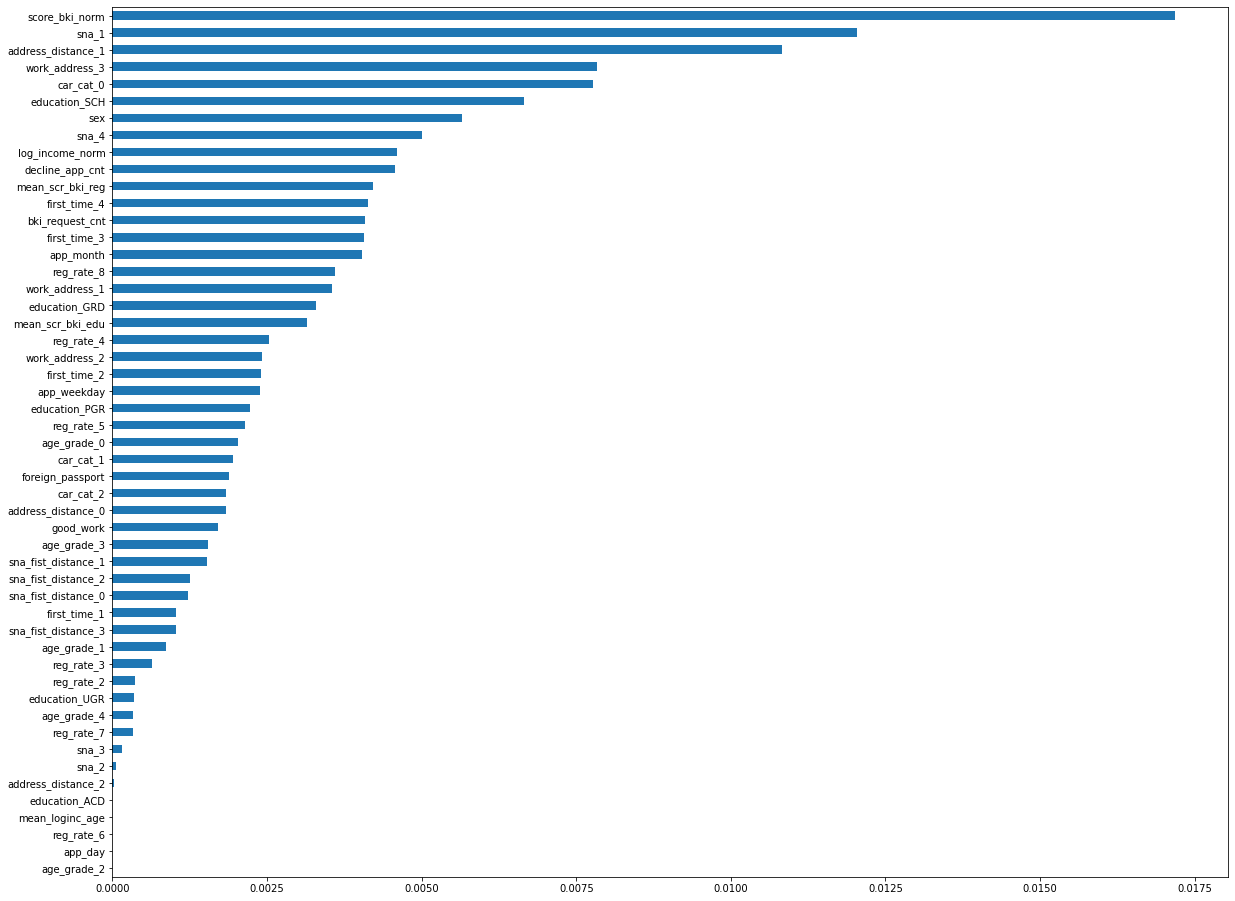

In [33]:
plt.figure(figsize=(20, 16))
imp_cat = Series(mutual_info_classif(train[model_cols], train.default), index=model_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh');

In [34]:
unimp_col=imp_cat[imp_cat<0.0001] ; unimp_col


age_grade_2           0.000000
app_day               0.000000
reg_rate_6            0.000000
mean_loginc_age       0.000000
education_ACD         0.000000
address_distance_2    0.000020
sna_2                 0.000063
dtype: float64

In [35]:
# list3 =  [x for x in list1 if x not in list2] - делает разность двух списков
model_cols = [x for x in model_cols if x not in unimp_col]
model_cols

['sex',
 'decline_app_cnt',
 'good_work',
 'bki_request_cnt',
 'foreign_passport',
 'app_weekday',
 'app_month',
 'log_income_norm',
 'score_bki_norm',
 'mean_scr_bki_reg',
 'mean_scr_bki_edu',
 'education_GRD',
 'education_PGR',
 'education_SCH',
 'education_UGR',
 'work_address_1',
 'work_address_2',
 'work_address_3',
 'sna_1',
 'sna_3',
 'sna_4',
 'first_time_1',
 'first_time_2',
 'first_time_3',
 'first_time_4',
 'reg_rate_2',
 'reg_rate_3',
 'reg_rate_4',
 'reg_rate_5',
 'reg_rate_7',
 'reg_rate_8',
 'age_grade_0',
 'age_grade_1',
 'age_grade_3',
 'age_grade_4',
 'car_cat_0',
 'car_cat_1',
 'car_cat_2',
 'address_distance_0',
 'address_distance_1',
 'sna_fist_distance_0',
 'sna_fist_distance_1',
 'sna_fist_distance_2',
 'sna_fist_distance_3']

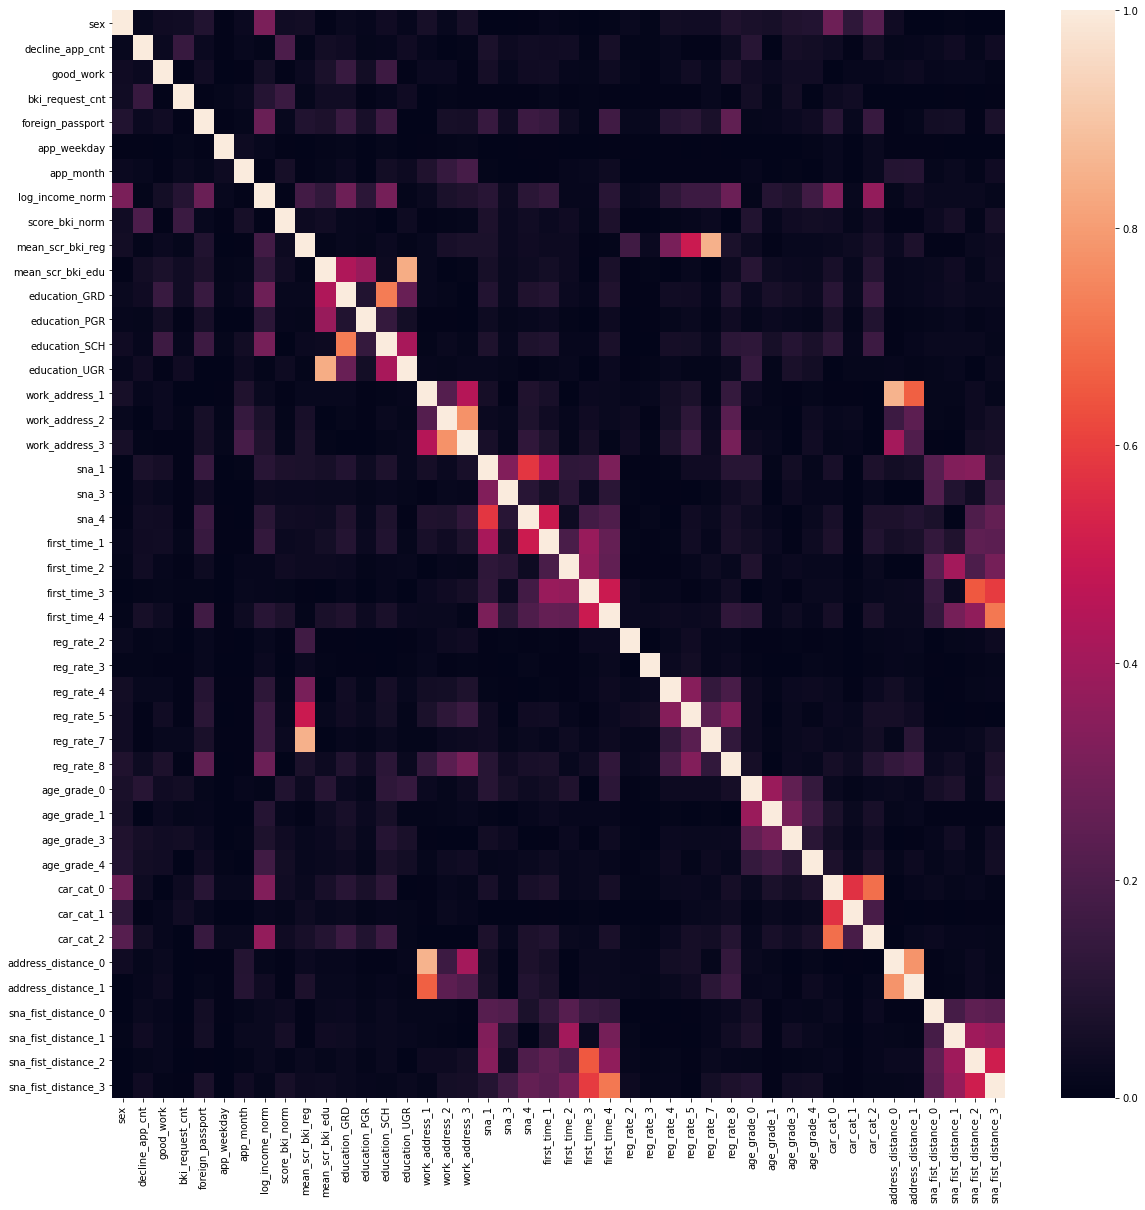

In [36]:
plt.figure(figsize=(20, 20))
sns.heatmap(train[model_cols].corr().abs(), vmin=0, vmax=1, annot = False);

In [37]:
show_high_corr_features(train,model_cols)

address_distance_0  work_address_1        0.851909
work_address_1      address_distance_0    0.851909
mean_scr_bki_reg    reg_rate_7            0.850715
reg_rate_7          mean_scr_bki_reg      0.850715
dtype: float64

In [38]:
high_corr_col = ['address+distance_0', 'reg_rate_7']
model_cols = [x for x in model_cols if x not in high_corr_col]

In [39]:
model_cols = [x for x in model_cols if x not in ['default'] ]

## Подбор гиперпараметров

После отбора работаающих признаков для модели возникла необходимость сделать очередной базовый сценарий для стадии поиска гиперпараметров.
Для можели логистической регрессии возникло желание использовать новую функцию LogisticRegressionCV, которая в дополнение к логистической регрессии и кросс-валидации позволяет сделать еще и мини-подбор единственного гиперпараметра C (в широком диапазоне и с редкой сеткой). Возникло желание срау же и подбор гиперпараметров сделать.
Модель логистической регрессии допускает указание различных вариантов скоринга для выбора лучшего варианта и по умолчанию используется accuracy. Поскольку у нас в задании целевым показателем является aucroc - он и выбран в качестве целевого (максимизируемого) показателя.

In [83]:
for slv in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    clf = LogisticRegressionCV( cv=5, random_state=0, scoring = 'roc_auc', solver=slv)
    clf = clf.fit(train[model_cols], train.default)
    #scores=clf.scores_
    print(f'Алгоритм: {slv}, AUCROC {clf.scores_[1].max():.6f}  C={clf.C_[0]:.6f}')


Алгоритм: newton-cg, AUCROC 0.746416  C=2.782559
Алгоритм: lbfgs, AUCROC 0.746410  C=2.782559
Алгоритм: liblinear, AUCROC 0.746410  C=21.544347
Алгоритм: sag, AUCROC 0.746414  C=2.782559
Алгоритм: saga, AUCROC 0.746413  C=2.782559


Первый шаг изучения разных алгоритмов расчета показал, что их результаты отличаются на сотую часть базисного пункта и С сосредоточен где-то в диапазоне от примерно 0.5 до 20.  Второй цикл подбора гиперпарамента был связан с максимальным количеством итераций. Он оказался не существенным - поиск сходился меньше чем за 100 итераций.

In [84]:
for m in [100,500,1000]:
    for slv in ['newton-cg', 'sag', 'saga']:
        clf = LogisticRegressionCV( cv=5, random_state=0, scoring = 'roc_auc', n_jobs=-1, solver=slv, max_iter=m)
        clf = clf.fit(train[model_cols], train.default)
        #scores=clf.scores_
        print(f'Алгоритм:{slv}, {m} итераций, AUCROC {clf.scores_[1].max():.6f} C={clf.C_[0]:.6f}')


Алгоритм:newton-cg, 100 итераций, AUCROC 0.746416 C=2.782559
Алгоритм:sag, 100 итераций, AUCROC 0.746414 C=2.782559
Алгоритм:saga, 100 итераций, AUCROC 0.746413 C=2.782559
Алгоритм:newton-cg, 500 итераций, AUCROC 0.746416 C=2.782559
Алгоритм:sag, 500 итераций, AUCROC 0.746414 C=2.782559
Алгоритм:saga, 500 итераций, AUCROC 0.746413 C=2.782559
Алгоритм:newton-cg, 1000 итераций, AUCROC 0.746416 C=2.782559
Алгоритм:sag, 1000 итераций, AUCROC 0.746414 C=2.782559
Алгоритм:saga, 1000 итераций, AUCROC 0.746413 C=2.782559


Третий цикл подбора гиперпараметра был связан с уточнением гиперпараметра С. Сначала был выбран диапазон от $e^{-1}$ до $e^{+3}$, поделенный на 8 частей. В следующей итерации он был поделен уже на 16 частей.  Параллельно уточнялся наилучший алгоритм подбора коэффициентов логистической регрессии.

In [97]:
Cs = list(np.exp(np.linspace(-1,3,9)))

In [98]:

for slv in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    clf = LogisticRegressionCV( cv=5, random_state=0, scoring = 'roc_auc', n_jobs=-1, Cs=Cs,  solver=slv)
    clf = clf.fit(train[model_cols], train.default)
    #scores=clf.scores_
    print(f'Алгоритм: {slv}, AUCROC {clf.scores_[1].max():.6f}  C={clf.C_[0]:.6f}')

Алгоритм: newton-cg, AUCROC 0.746399  C=1.648721
Алгоритм: lbfgs, AUCROC 0.746313  C=1.648721
Алгоритм: liblinear, AUCROC 0.746394  C=1.648721
Алгоритм: sag, AUCROC 0.746397  C=1.648721
Алгоритм: saga, AUCROC 0.746395  C=1.648721


In [99]:
Cs = list(np.exp(np.linspace(-1,3,17))); Cs

[0.36787944117144233,
 0.4723665527410147,
 0.6065306597126334,
 0.7788007830714049,
 1.0,
 1.2840254166877414,
 1.6487212707001282,
 2.117000016612675,
 2.718281828459045,
 3.4903429574618414,
 4.4816890703380645,
 5.754602676005731,
 7.38905609893065,
 9.487735836358526,
 12.182493960703473,
 15.642631884188171,
 20.085536923187668]

In [100]:
for slv in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    clf = LogisticRegressionCV( cv=5, random_state=0, scoring = 'roc_auc', n_jobs=-1, Cs=Cs,  solver=slv)
    clf = clf.fit(train[model_cols], train.default)
    #scores=clf.scores_
    print(f'Алгоритм: {slv}, AUCROC {clf.scores_[1].max():.6f}  C={clf.C_[0]:.6f}')

Алгоритм: newton-cg, AUCROC 0.746399  C=1.284025
Алгоритм: lbfgs, AUCROC 0.746401  C=2.117000
Алгоритм: liblinear, AUCROC 0.746394  C=2.117000
Алгоритм: sag, AUCROC 0.746397  C=1.284025
Алгоритм: saga, AUCROC 0.746395  C=1.284025


Результаты расчета с разными значениями гиперпараметров показывают определенную робастность процесса. Значение целевой функции колеблется на один базисный пункт, при значении С в районе 2. Кроме того лидерство алгоритмов расчета гиперпараметров меняется. Вероятно оно зависит от случайного разделения на наборы для кросс-валидации, на которое однако нельзя повлиять в параметрах LogisticRegressionCV.  По итогам общего зачета более предпочтительным выбран гиперпараметр-алгоритм 'newton-cg'.

Более точно выбрать модель и подобрать значение параметра С можно было бы при отказе от использования готовых решений для кросс-проверки и перебора гиперпараметров по сетке. В этом случае можно было зы задействовать и обучение на случайным образом добалансированной выборке.


In [104]:
best_clf = LogisticRegressionCV( cv=5, random_state=0, scoring = 'roc_auc', n_jobs=-1, Cs=[2.117],  solver='newton-cg')
best_clf = best_clf.fit(train[model_cols], train.default)


Алгоритм: saga, AUCROC 0.746294  C=2.117000


## Генерация данных для тестовой выборки

По условиям учебной задачи была предоставленая отдельная тестовая выборка, для которой необходимо сгенерировать результат вероятности (!) классификации клиентов. Результат классификации в виде файла из двух столбцов - идентификатор клиента и вероятность классификации необходимо загрузить на kaggle для выяснения итоговой оценки за классификацию.

Почти вся работа сделана локально.  Опыт работы с kaggle показал меньшую производительность среды по сравнению с локальным компьютером и ошибки в зависимостях - модуль LogisticRegressionCV устойчиво выдавал ошибку.  Поэтому итоговый результат классификации тоже будет сформирован локально и загружен в облако для целей выставления оценки.

In [105]:
test = pd.read_csv('test.csv')
test.shape

(36349, 18)

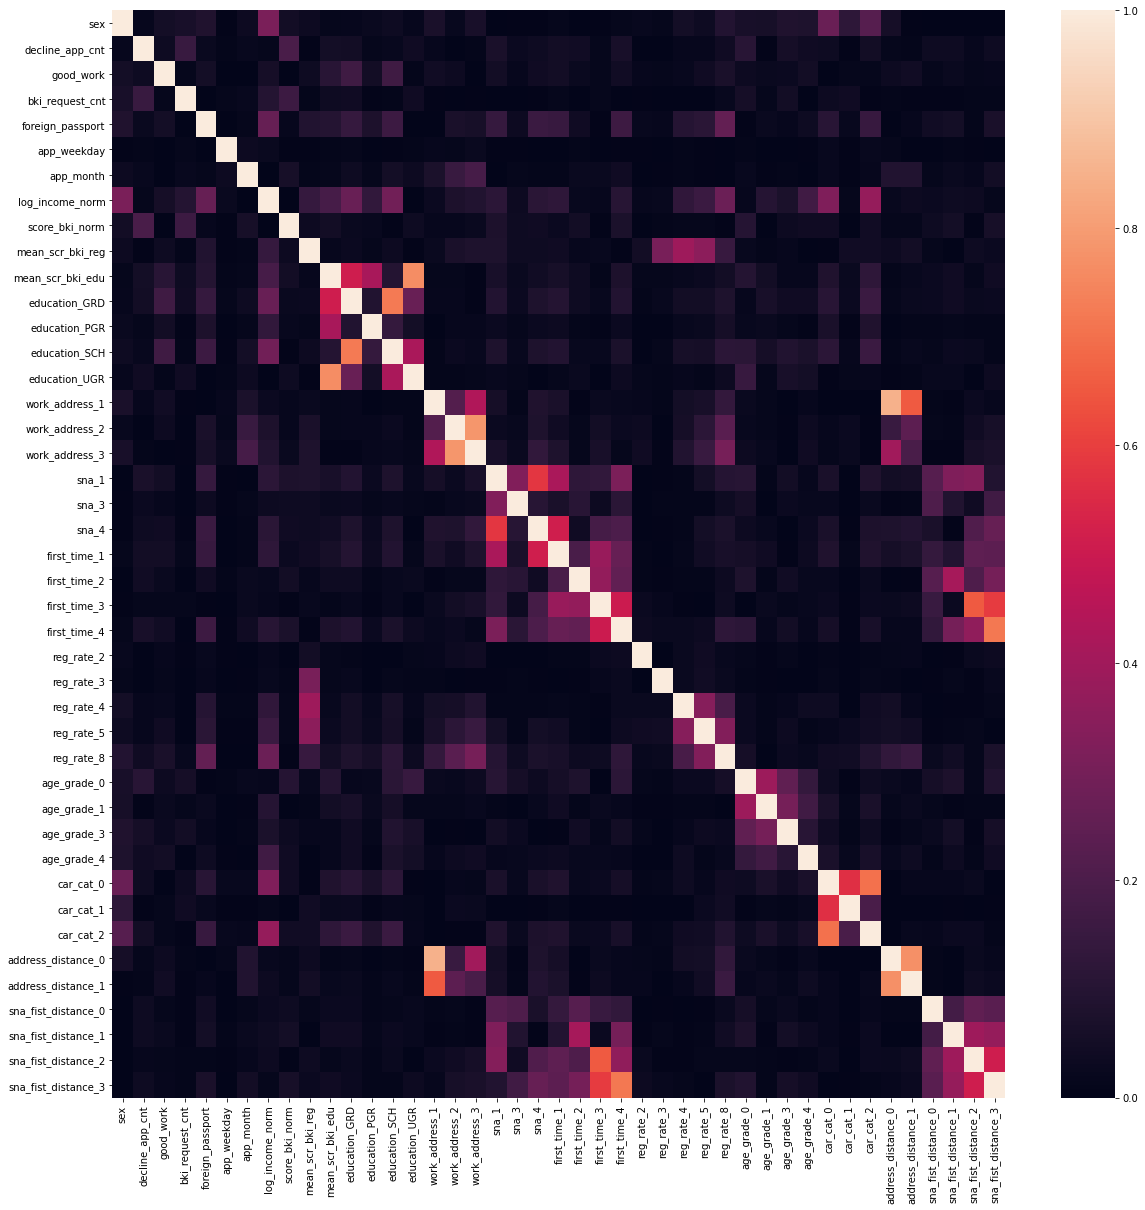

In [106]:
test = preprocessing(test)
plt.figure(figsize=(20, 20))
sns.heatmap(test[model_cols].corr().abs(), vmin=0, vmax=1, annot = False);

In [107]:
show_high_corr_features(test,model_cols)

Series([], dtype: float64)

In [111]:
# test[model_cols].info()

In [112]:
prediction = best_clf.predict_proba(test[model_cols])
result = pd.DataFrame(data={'client_id':test['client_id'], 'default':prediction[:,1]})
result.head(10)

,client_id,default
0,74835,0.033792
1,17527,0.451890
2,75683,0.053546
3,26883,0.077565
4,28862,0.026132
5,99881,0.226167
6,26630,0.398093
7,79934,0.027587
8,16605,0.031509
9,105449,0.027041


In [113]:
result.to_csv('submission.csv', index=False)

По результатам загрузки на kaggle результат (качество предсказания) оказался 0.73763 и он занял 104 место в публичном рейтинге.

## Итоговые выводы

1. Представленный набор данных отличается несбалансированностью, клиентов, допустивших дефолт по кредиту в несколько (примерно в 6,5) раз меньше чем хороших клиентов. Вероятно это отражает степень агрессивности кредитной политики кредитора, предоставившего набор.

2. В данных есть совокупность категориальных признаков с относительно высокой взаимной корреляцией - home_address и work_address. Возможно есть смысл проверить бизнес-аспекты формирования этих признаков и как-то объединить их, или предоставить больше информации для объединения на этапе подготовки данных. Предоставлены данные в целом достаточно хорошего качества - пропусков было небольшое количество и только по графе образование.

3. При преобразовании исходных данных удалось сохранить прозрачность исходных данных. Было несколько операций логарифмирования, с сохраненением исходных значений признаков в оргинальных столбцах.

4. При обучении модели целесообразно использовать разделение на группы с последующей балансировкой до примерно сбалансированных классов. Для этого можно использовать простейший алгоритм Random Oversampling из библиотеки imbalance learning. Обучение на дополнительно сбалансированных данных позволит в дальнейшем подстроить порог выявления "плохих заемщиков" исходя из бизнес-тратегии кредитора.

5. При обучении моделей проводилось наблюдение за метриками качества.  Предложенная по заданию метрика AUCROC рассчитывается на основе результатов классификации до срабатывания порога и потому ее максимизация хорошо сказывается на качестве итоговой модели. Хорошо показала себя метрика F1-score, входящая в стандартный функционал scikit learn.  Первоначально была идея использовать матрицу конфуза, затем рассчитывать на ее основе "анти-"метрики FNR и FPR. Изучение показало, что достаточно добиться максимального значения площади под кривой классификации AUCROC, а метрики затем поставить в оптимальных точках этой кривой.


6. При работе над моделью проводилось наблюдение над различными алгоритмами классификации - логстическая регрессия, решающие деревья и ансамбли из них. Исследование показало, что логистическая регрессия смотрится хорошо на фоне более сложных ансамблей и при этом сохраняет прозрачность данных. В целом исходя из прозрачности данных (и более высокого доверия к результатам машинного обучения) в итоге использован алгоритм логистической регрессии.

7. Подбор гиперпараметров проведен по упрощенной схеме.  Подбор показал целесообразность использования гиперпараметра С = 2, и не высокий разброс итоговых значений AUCROC в зависимости от алгоритма подбора параметров. Различие на этапе подбора было повидимому связано с неконролируемой случайностью разделения на обучающие и тестовые выборки.

8. Раота с моделью сопровождалась попыткой разработать трансформер для исходных данных. В целом работа почти получилась и показала привлекательность такого решения.  Итоговый код представляет собой почти трансформер с ручным указанием признаков, которые должны быть отброшены на последнем этапе. Этот шаг тоже можно автоматизировать на основе автоматического отбрасывания признаков с высокой степенью корреляции с выбором наименее значимого признака из пары.